Part IV: Elastic Net Regularization using Gradient Descent
=======================================================


In [86]:
import numpy as np 
import matplotlib.pyplot as plt
import pandas as pd
from math import sqrt

In [87]:
diamonds_df = pd.read_csv("diamonds_preprocessed.csv")
diamonds_df = diamonds_df.drop(columns='Unnamed: 0')
print('Dropping unrelated column \"Unnamed: 0\" since it is not required')
diamonds_df.info()

Dropping unrelated column "Unnamed: 0" since it is not required
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 51334 entries, 0 to 51333
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   carat   51334 non-null  float64
 1   table   51334 non-null  float64
 2   price   51334 non-null  float64
 3   x       51334 non-null  float64
 4   y       51334 non-null  float64
 5   z       51334 non-null  float64
dtypes: float64(6)
memory usage: 2.4 MB


In [88]:
X = diamonds_df[['carat', 'table', 'x', 'y', 'z']].values
y = diamonds_df['price'].values.reshape(-1, 1) 
N = X.shape[0]
train_size = int(0.8 * N)
index_number = np.arange(N)
np.random.shuffle(index_number)
train_indices = index_number[:train_size]
test_indices = index_number[train_size:]
X_train = X[train_indices]
y_train = y[train_indices]
X_test = X[test_indices]
y_test = y[test_indices]
min_values = X_train.min(axis=0)
max_values = X_train.max(axis=0)
X_train_normalized = (X_train - min_values) / (max_values - min_values)
X_test_normalized = (X_test - min_values) / (max_values - min_values)
X_train_bias = np.c_[np.ones((X_train_normalized.shape[0], 1)), X_train_normalized]
X_test_bias = np.c_[np.ones((X_test_normalized.shape[0], 1)), X_test_normalized]

print("X_train_bias shape:", X_train_bias.shape)
print("y_train shape:", y_train.shape)
print("X_test_bias shape:", X_test_bias.shape)
print("y_test shape:", y_test.shape)

X_train_bias shape: (41067, 6)
y_train shape: (41067, 1)
X_test_bias shape: (10267, 6)
y_test shape: (10267, 1)


In [96]:
def elastic_net_loss(X, y, w, lambda1, lambda2):
    N = len(y)
    predictions = X.dot(w)
    error = predictions - y
    mse_loss = (1 / (2 * N)) * np.sum(error ** 2)
    l2_penalty = (lambda1 / 2) * np.sum(w ** 2)
    l1_penalty = lambda2 * np.sum(np.abs(w))
    return mse_loss + l2_penalty + l1_penalty

def gradient_descent(X, y, w, lambda1, lambda2, alpha, epochs, threshold=None):
    loss_history = []
    N, d = X.shape
    for epoch in range(epochs):
        predictions = X.dot(w)
        error = predictions - y
        gradient = (1 / N) * X.T.dot(error) + lambda1 * w + lambda2 * np.sign(w)
        w -= alpha * gradient

        loss = elastic_net_loss(X, y, w, lambda1, lambda2)
        loss_history.append(loss)
        
        if epoch % 10 == 0:
            print(f"Epoch {epoch}, Loss: {loss}")

        if threshold is not None and np.all(np.abs(gradient) < threshold):
            print(f"Stopping early at iteration {epoch} due to small gradient.")
            break
    
    return w, loss_history

def random_initialization(input_dim, output_dim):
    return np.random.randn(input_dim, output_dim)

def zero_initialization(input_dim, output_dim):
    return np.zeros((input_dim, output_dim))

def xavier_initialization(input_dim, output_dim):
    limit = sqrt(6 / (input_dim + output_dim))
    return np.random.uniform(-limit, limit, size=(input_dim, output_dim))


def three_initialization_methods(X_train, y_train, X_test, y_test, lambda1, lambda2, alpha, epochs):
    input_dim, output_dim = X_train.shape[1], 1

    w_random = random_initialization(input_dim, output_dim)
    print("\nTraining with Random Initialization:")
    w_random, loss_random = gradient_descent(X_train, y_train, w_random, lambda1, lambda2, alpha, epochs)

    w_zero = zero_initialization(input_dim, output_dim)
    print("\nTraining with Zero Initialization:")
    w_zero, loss_zero = gradient_descent(X_train, y_train, w_zero, lambda1, lambda2, alpha, epochs)

    w_xavier = xavier_initialization(input_dim, output_dim)
    print("\nTraining with Xavier Initialization:")
    w_xavier, loss_xavier = gradient_descent(X_train, y_train, w_xavier, lambda1, lambda2, alpha, epochs)

    return (w_random, loss_random), (w_zero, loss_zero), (w_xavier, loss_xavier)

def plot_results_for_initialization_methods(X_test, y_test, w, loss_history, init_method_name):
    predictions = X_test.dot(w)
    plt.figure(figsize=(10, 5))
    plt.scatter(range(len(y_test)), y_test, label='Actual', alpha=0.3, color='blue', edgecolor='k')
    plt.scatter(range(len(predictions)), predictions, label='Predicted', alpha=0.7, color='red')
    plt.plot([0, len(y_test)], [min(y_test), max(y_test)], color='green', linestyle='--', linewidth=2, label='Ideal (y=x)')
    
    plt.title(f'Predictions vs Actual Values ({init_method_name} Initialization)')
    plt.xlabel('Data points')
    plt.ylabel('Values')
    plt.legend(loc='upper right')
    plt.show()

    plt.figure(figsize=(10, 5))
    plt.plot(range(len(loss_history)), loss_history)
    plt.title(f'Convergence Plot - {init_method_name} Initialization')
    plt.xlabel('Iterations')
    plt.ylabel('Loss')
    plt.show()

def plot_predictions(X_test, y_test, w):
    predictions = X_test.dot(w)
    plt.figure()
    plt.scatter(range(len(y_test)), y_test, label='Actual', alpha=0.3, color='blue', edgecolor='k')
    plt.scatter(range(len(predictions)), predictions, label='Predicted', alpha=0.7, color='red')
    plt.title('Predictions vs Actual Values')
    plt.xlabel('Data points')
    plt.ylabel('Values')
    plt.legend()
    plt.show()

def plot_loss_convergence(loss_history, stopping_criterion_name):
    plt.figure()
    plt.plot(range(len(loss_history)), loss_history)
    plt.title(f'Convergence Plot - {stopping_criterion_name}')
    plt.xlabel('Iterations')
    plt.ylabel('Loss')
    plt.show()

def experiment_with_stopping_criteria(X_train, y_train, X_test, y_test, lambda1, lambda2, alpha):
    input_dim, output_dim = X_train.shape[1], 1
    max_iterations = 100000  # Max iterations for threshold stopping criterion

    w = xavier_initialization(input_dim, output_dim)
    
    print("\nTraining with 100 iterations stopping criterion:")
    w_predefined, loss_predefined = gradient_descent(X_train, y_train, w, lambda1, lambda2, alpha, 100)
    print("\nModel evaluation for predefined stopping criterion:")
    plot_predictions(X_test, y_test, w_predefined)
    plot_loss_convergence(loss_predefined, 'Predefined iterations (1000)')
    
    w = xavier_initialization(input_dim, output_dim)
    
    print("\nTraining with gradient threshold stopping criterion:")
    w_grad_threshold, loss_grad_threshold = gradient_descent(X_train, y_train, w, lambda1, lambda2, alpha, max_iterations, threshold=0.08)
    print("\nModel evaluation for gradient threshold stopping criterion:")
    plot_predictions(X_test, y_test, w_grad_threshold)
    plot_loss_convergence(loss_grad_threshold, 'Gradient threshold (0.08)')

    return w_predefined, w_grad_threshold


Training with Random Initialization:
Epoch 0, Loss: 3.060044473937338
Epoch 10, Loss: 2.16337540625874
Epoch 20, Loss: 1.5631649767544735
Epoch 30, Loss: 1.1587210709327234
Epoch 40, Loss: 0.8975396496249575
Epoch 50, Loss: 0.7243694522578235
Epoch 60, Loss: 0.6045038533319875
Epoch 70, Loss: 0.5202753172218089
Epoch 80, Loss: 0.4599046534869383
Epoch 90, Loss: 0.4155376743350282

Training with Zero Initialization:
Epoch 0, Loss: 0.05576325964663453
Epoch 10, Loss: 0.0538360299814904
Epoch 20, Loss: 0.05244522924564682
Epoch 30, Loss: 0.05141528089746636
Epoch 40, Loss: 0.050629046155172525
Epoch 50, Loss: 0.05000834201904791
Epoch 60, Loss: 0.049500955270999555
Epoch 70, Loss: 0.049093432858480224
Epoch 80, Loss: 0.04876090622645343
Epoch 90, Loss: 0.04850067355392808

Training with Xavier Initialization:
Epoch 0, Loss: 0.7578221880703415
Epoch 10, Loss: 0.7114828779338824
Epoch 20, Loss: 0.6713659322848153
Epoch 30, Loss: 0.635721202449911
Epoch 40, Loss: 0.603370331899997
Epoch 50,

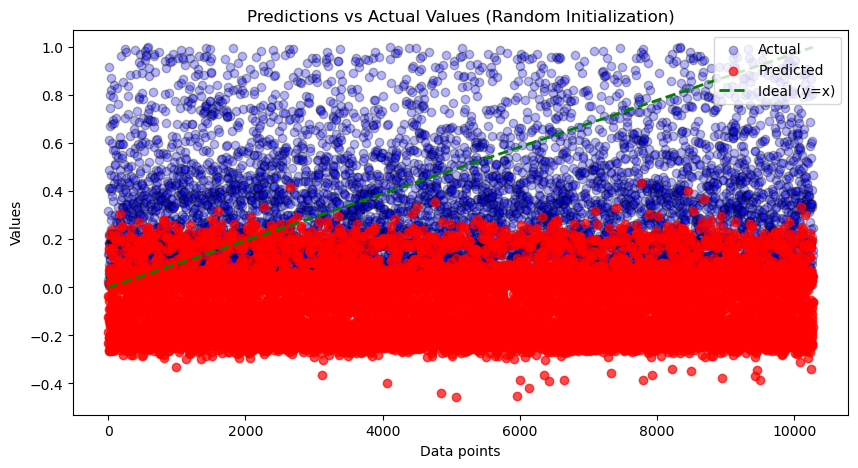

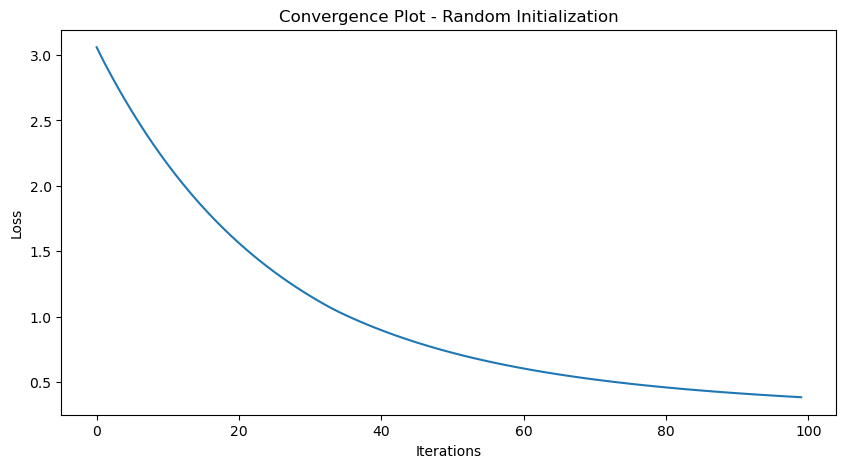

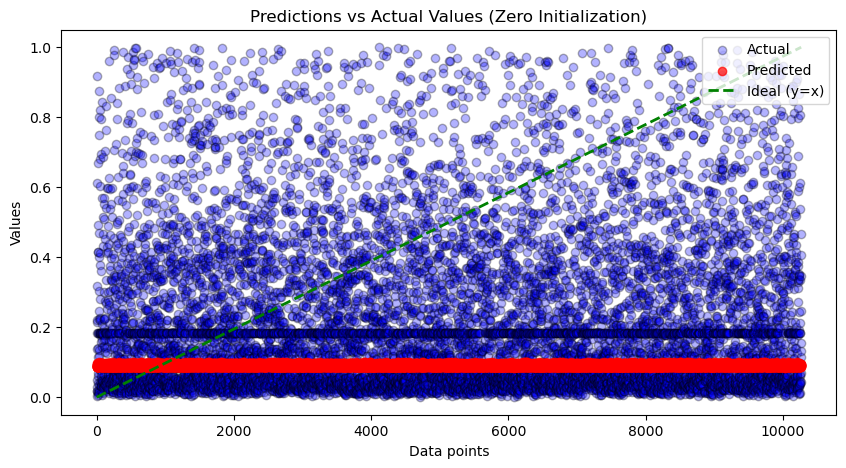

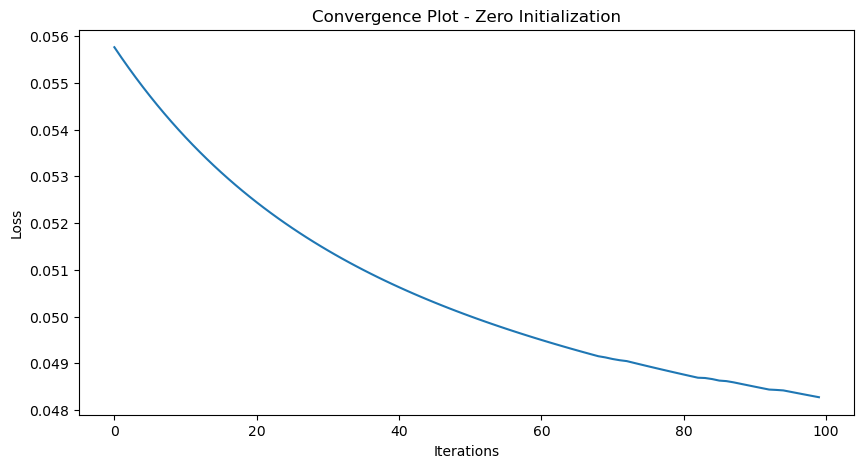

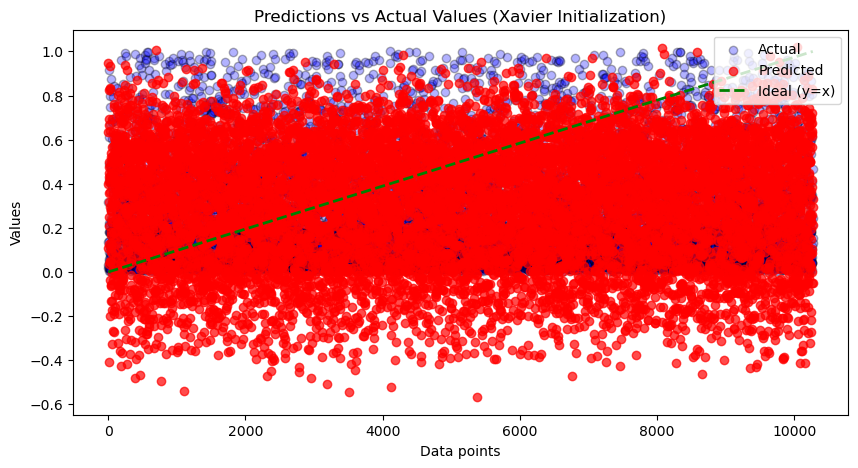

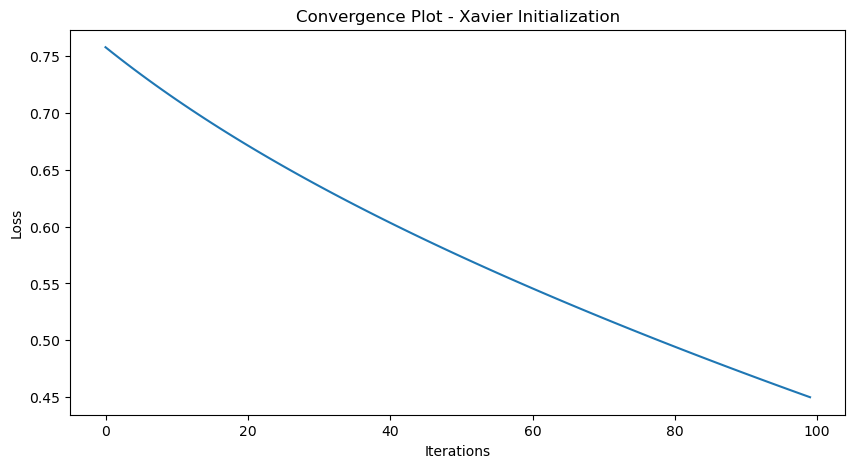

In [90]:
lambda1 = 0.1  # L2 regularization parameter
lambda2 = 0.1  # L1 regularization parameter
alpha = 0.01
epochs = 100

(w_random, loss_random), (w_zero, loss_zero), (w_xavier, loss_xavier) = three_initialization_methods(X_train_bias, y_train, X_test_bias, y_test, lambda1, lambda2, alpha, epochs)
plot_results_for_initialization_methods(X_test_bias, y_test, w_random, loss_random, "Random")
plot_results_for_initialization_methods(X_test_bias, y_test, w_zero, loss_zero, "Zero")
plot_results_for_initialization_methods(X_test_bias, y_test, w_xavier, loss_xavier, "Xavier")


Training with 100 iterations stopping criterion:
Epoch 0, Loss: 1.4066269257992745
Epoch 10, Loss: 0.9692347072072263
Epoch 20, Loss: 0.6751626180038296
Epoch 30, Loss: 0.47669857954633066
Epoch 40, Loss: 0.34761556379493364
Epoch 50, Loss: 0.2630434659958131
Epoch 60, Loss: 0.20406266070053436
Epoch 70, Loss: 0.16259894949022233
Epoch 80, Loss: 0.13679518722693906
Epoch 90, Loss: 0.11726335621423946

Model evaluation for predefined stopping criterion:


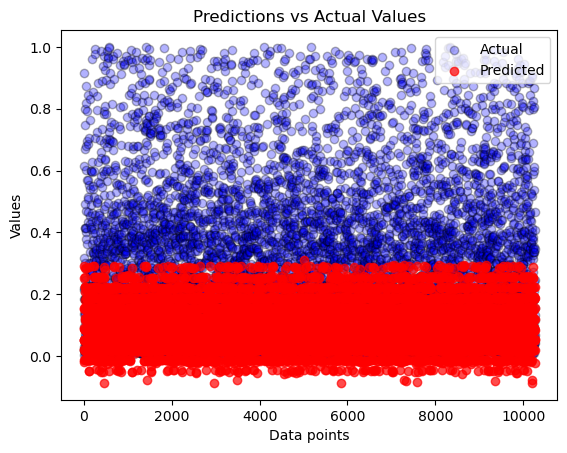

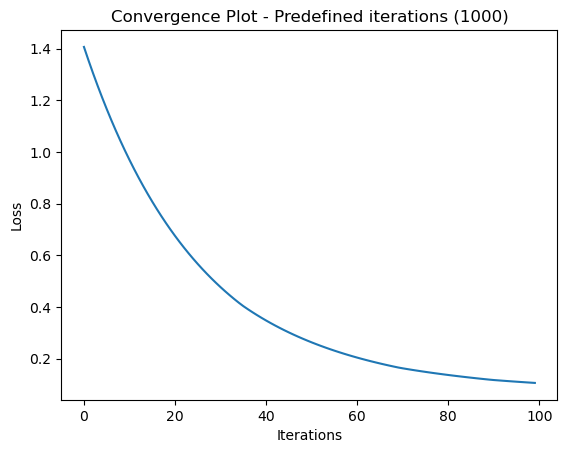


Training with gradient threshold stopping criterion:
Epoch 0, Loss: 0.4404106494020913
Epoch 10, Loss: 0.3833668364519408
Epoch 20, Loss: 0.3415776151598652
Epoch 30, Loss: 0.3100800563105591
Epoch 40, Loss: 0.2855618533647042
Epoch 50, Loss: 0.26581108513217616
Epoch 60, Loss: 0.24934944511781948
Epoch 70, Loss: 0.2351877623031835
Epoch 80, Loss: 0.22266303649347355
Epoch 90, Loss: 0.21132980805987533
Epoch 100, Loss: 0.2008877449019061
Epoch 110, Loss: 0.1913443445544054
Epoch 120, Loss: 0.18248047979133958
Epoch 130, Loss: 0.17408259413615318
Epoch 140, Loss: 0.16607002093787257
Epoch 150, Loss: 0.15838674339925865
Epoch 160, Loss: 0.1509932981796807
Epoch 170, Loss: 0.14386117967996484
Epoch 180, Loss: 0.13696927152505484
Epoch 190, Loss: 0.1303022452974217
Epoch 200, Loss: 0.12384696177831955
Epoch 210, Loss: 0.1176389809241761
Epoch 220, Loss: 0.11163974327237908
Epoch 230, Loss: 0.10578698261392
Epoch 240, Loss: 0.10009281767196215
Epoch 250, Loss: 0.09457185501818291
Epoch 260

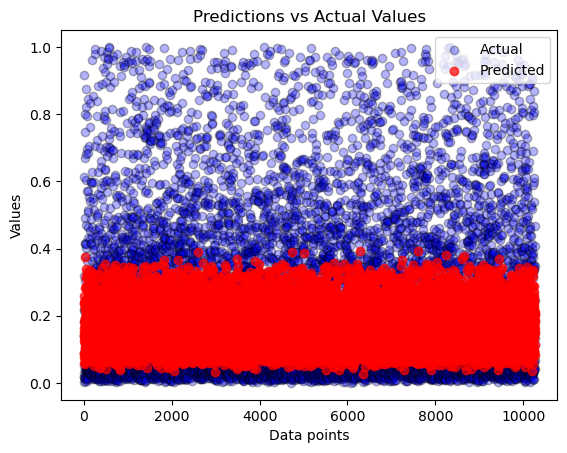

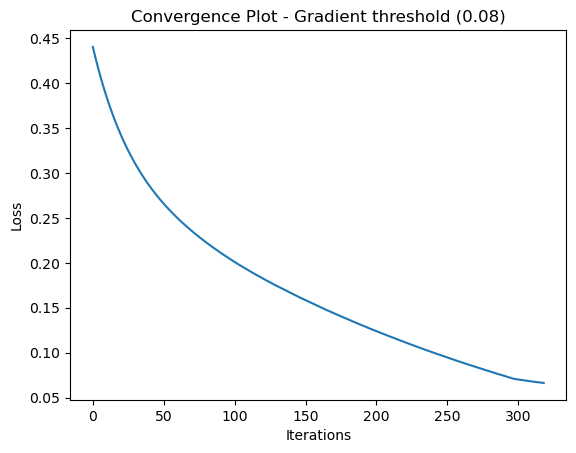

In [97]:
w_predefined, w_grad_threshold = experiment_with_stopping_criteria(X_train_bias, y_train, X_test_bias, y_test, lambda1, lambda2, alpha)